In [55]:
import numpy as np
import pandas as pd
import seaborn as sns


# ML Workflow

A construção dos modelos de Machine Learning muitas vezes depende mais da qualidade dos dados e dos cuidados tomados contra **data leakage** do que das escolhas técnicas do cientista de dados. Hoje veremos um *workflow* padrão para a trabalhar com conjuntos de dados - garantindo que não exista leakage e que nosso conjunto de treinamento está limpo.

Além disso, devemos sempre lembrar que os modelos preditivos **existem para fazer previsões**! Um dos maiores problemas hoje em dia no campo de machine learning é a dificuldade em levar um modelo da fase de protótipo à produção. Vamos discutir ao longo da aula pontos sensíveis na implantação de um modelo e que como podemos evitar armadilhas.

In [56]:
tb_hotel = pd.read_csv("data/tb_hotel_aula.csv")
tb_hotel.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 10 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   is_cancelled             119390 non-null  int64  
 1   lead_time                119390 non-null  int64  
 2   country                  118902 non-null  object 
 3   company                  6797 non-null    float64
 4   children                 119386 non-null  float64
 5   adults                   119390 non-null  int64  
 6   meal                     119390 non-null  object 
 7   adr                      119390 non-null  float64
 8   reservation_status_date  119390 non-null  object 
 9   booking_changes          119390 non-null  int64  
dtypes: float64(3), int64(4), object(3)
memory usage: 9.1+ MB


## Evitando *leakage*

*Data leakage* é um erro extremamente comum no campo de ciência de dados. Em uma análise feita para um [artigo da revista Nature](https://www.nature.com/articles/d41586-022-02035-w), em um review de 340 artigos, 329 apresentavam **falhas em reprodutibilidade**. Outro estudo, conduzido na Universidade de Birmingham, apontou que menos de 5% dos artigos médicos utilizando Machine Learning se preocupavam com a possibilidade de implantação dos modelos em ambiente clínicos.

*Leakage* acontece quando não garantimos, na etapa de construção do modelo, que estamos operando dentro das mesmas condições que o modelo irá operar quando estiver em produção. Para garantir estas condições precisamos cumprir duas etapas:

1. **Limpeza de variáveis**: como conjuntos de dados utilizados na construção de modelos são sempre dados históricos, precisamos garantir que as variáveis que estamos utilizando estarão disponíveis do momento em que o modelo for utilizado para fazer previsões;
1. **Avaliação de Erro em conjunto Teste**: para modelos preditivos, precisamos avaliar o erro de previsão destes modelos em conjuntos de dados que não foram utilizados nas etapas de aprendizagem.

Na primeira etapa **precisamos descobrir e entender como o dado é produzido**: quais sistemas são utilizados, quais são os *fatos transacionais*, e, finalmente, quais as informações que estarão disponíveis no momento de predição. Além disso, precisamos **garantir** que as etapas de pré-processamento do modelo **funcionarão** sobre dados futuros!

Excluindo variáveis que não estarão disponíveis em sua forma histórica em dados presentes, a divisão test/train possibilita que avaliemos o modelo em todas as suas etapas: pré-processamento, aprendizagem e avaliação.

In [57]:
from sklearn.model_selection import train_test_split


In [58]:
X_var = ["lead_time", "country", "company", "children", "adults", "meal", "adr"]
y_var = "is_cancelled"
X = tb_hotel[X_var]
y = tb_hotel[y_var]
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y)


## Tratando NAs

Para tratar de valores NA em um modelo de machine learning, não basta *exluir linhas*! Temos que lembrar que, em produção, os dados alimentados ao modelo poderão conter NAs. Precisamos criar mecânismos que **preencham** esses valores ou então desncosiderar as variáveis que podem conte-los.

In [60]:
X_train.isna().sum() / X_train.shape[0]


lead_time    0.000000
country      0.004244
company      0.943110
children     0.000022
adults       0.000000
meal         0.000000
adr          0.000000
dtype: float64

### Tratativas Manuais

A melhor forma de tratar valores NA é compreendendo **porque eles existem** em uma dada variável. Se conhecemos as causas por trás destes valores, podemos criar tratativas diretas e específicas à cada variável.

In [61]:
mask_na_company = X_train["company"].isna()

X_train.loc[mask_na_company, "is_company"] = 0
X_train.loc[~mask_na_company, "is_company"] = 1


### Imputando valores

Caso não seja possível elucidar porque certas variáveis contém NAs, podemos recorrer a **imputação de valores**. A imputação pode ser arriscada se os valores não foram gerados por erros de sistema, ou então se tem uma estrutura subjacente, portanto devemos utiliza-la apenas após estudar o processo de geração de dados e garantir que estes valores são:

1. Raros;
1. Causados por falhas no sistema;

In [62]:
from sklearn.impute import SimpleImputer


In [63]:
country_imputer = SimpleImputer(strategy="most_frequent")
country_imputer.fit(X_train[["country"]])


SimpleImputer(strategy='most_frequent')

In [64]:
children_imputer = SimpleImputer(strategy="median")
children_imputer.fit(X_train[["children"]])


SimpleImputer(strategy='median')

In [65]:
X_train["country_imp"] = country_imputer.transform(X_train[["country"]])
X_train["children_imp"] = children_imputer.transform(X_train[["children"]])


In [66]:
X_train.isna().sum()


lead_time           0
country           380
company         84448
children            2
adults              0
meal                0
adr                 0
is_company          0
country_imp         0
children_imp        0
dtype: int64

In [67]:
X_train.loc[X_train["country"].isna(), ["country", "country_imp"]]


,country,country_imp
14221,NaN,PRT
13978,NaN,PRT
23487,NaN,PRT
23527,NaN,PRT
14629,NaN,PRT
...,...,...
9612,NaN,PRT
14206,NaN,PRT
15181,NaN,PRT
14347,NaN,PRT


In [68]:
X_train.loc[X_train["children"].isna(), ["children", "children_imp"]]


,children,children_imp
40600,NaN,0.0
41160,NaN,0.0


### Removendo colunas

Caso uma coluna não tenha uma trativa direta e contém valores NA demais para imputação, devemos desconsiderar esta variável no nosso modelo.

In [69]:
X_train = X_train.drop(["company", "country", "children"], axis=1)
X_train.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 89542 entries, 108543 to 101980
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lead_time     89542 non-null  int64  
 1   adults        89542 non-null  int64  
 2   meal          89542 non-null  object 
 3   adr           89542 non-null  float64
 4   is_company    89542 non-null  float64
 5   country_imp   89542 non-null  object 
 6   children_imp  89542 non-null  float64
dtypes: float64(3), int64(2), object(2)
memory usage: 5.5+ MB


## Lidando com Variáveis Categóricas

As variáveis categóricas apresentam algumas dificuldades quando utilizadas em modelos:

1. No caso de One-Hot encoding, devemos garantir que nosso programa **saiba lidar com níveis novos da variável**;
1. Além disso, precisamos garantir que não criemos variáveis dummies para níveis com poucas observações (níveis raros).

No caso de utilizarmos variáveis **Ordinais**, precisamos garantir que a **codificação** destas variáveis faça sentido!

In [70]:
X_train.select_dtypes(exclude="number").head()


,meal,country_imp
108543,BB,ISR
118204,BB,HUN
16233,BB,PRT
113113,BB,AUS
10827,BB,PRT


In [71]:
cat_vars = ["country_imp"]
ord_vars = ["meal"]


### Tratando níveis raros

A forma mais comum de tratar níveis raros é agrupando-os em uma nova categoria.

In [72]:
tb_niveis_country = (
    X_train[cat_vars].value_counts().reset_index().rename({0: "num_obs"}, axis=1)
)
tb_niveis_country


,country_imp,num_obs
0,PRT,36784
1,GBR,9089
2,FRA,7829
3,ESP,6373
4,DEU,5503
...,...,...
161,SLV,1
162,SMR,1
163,LCA,1
164,HND,1


In [73]:
mask_niveis = tb_niveis_country["num_obs"] > (sum(tb_niveis_country["num_obs"]) * 0.01)
tb_niveis_country.loc[mask_niveis, "country_grp"] = tb_niveis_country["country_imp"]
tb_niveis_country.loc[~mask_niveis, "country_grp"] = "Others"
tb_niveis_country.index = tb_niveis_country["country_imp"]
tb_niveis_country = tb_niveis_country.drop(["num_obs", "country_imp"], axis=1)
tb_niveis_country


,country_grp
country_imp,
PRT,PRT
GBR,GBR
FRA,FRA
ESP,ESP
DEU,DEU
...,...
SLV,Others
SMR,Others
LCA,Others


In [74]:
dict_country = tb_niveis_country.to_dict()["country_grp"]
X_train["country_grp"] = X_train["country_imp"].map(dict_country)
X_train = X_train.drop("country_imp", axis=1)
X_train.head()


,lead_time,adults,meal,adr,is_company,children_imp,country_grp
108543,158,2,BB,95.00,0.0,0.0,Others
118204,170,2,BB,130.50,0.0,0.0,Others
16233,0,2,BB,165.00,0.0,0.0,PRT
113113,409,2,BB,112.67,0.0,0.0,Others
10827,47,1,BB,103.33,0.0,0.0,PRT


### One-Hot Encoding

Após tratarmos níveis raros, podemos utilizar o `OneHotEncoder` para criar nossa variáveis dummies de forma robusta, garantindo que novos níveis em dados futuros (ou no conjunto de teste) não causarão erros em nosso modelo.

In [75]:
from sklearn.preprocessing import OneHotEncoder


In [76]:
ohe_vars = ["country_grp"]


In [77]:
ohe = OneHotEncoder(sparse=False, drop="first", handle_unknown="ignore")
ohe.fit(X_train[ohe_vars])


OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

In [78]:
ohe.transform(X_train[ohe_vars])


array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [79]:
tb_dummies_cat = pd.DataFrame(
    ohe.transform(X_train[ohe_vars]), columns=ohe.get_feature_names_out(), index = X_train.index
)
tb_dummies_cat.head()


,country_grp_BEL,country_grp_BRA,country_grp_CHE,country_grp_CN,country_grp_DEU,country_grp_ESP,country_grp_FRA,country_grp_GBR,country_grp_IRL,country_grp_ITA,country_grp_NLD,country_grp_Others,country_grp_PRT,country_grp_USA
108543,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
118204,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
16233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
113113,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
10827,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### Variáveis Ordinais

Além do One-Hot Encoding, podemos converter nossas categorias em variáveis numéricas (se elas possuem um ordenamento natural). Vamos utilizar o `OrdinalEncoder` para tratar a variável `meal`.

In [80]:
from sklearn.preprocessing import OrdinalEncoder


In [81]:
X_train["meal"].value_counts()


BB           69265
HB           10856
SC            7952
Undefined      870
FB             599
Name: meal, dtype: int64

In [82]:
ordinal = OrdinalEncoder(categories=[["Undefined", "SC", "BB", "HB", "FB"]])
ordinal.fit(X_train[["meal"]])


OrdinalEncoder(categories=[['Undefined', 'SC', 'BB', 'HB', 'FB']])

In [83]:
X_train["num_meal"] = ordinal.transform(X_train[["meal"]])
X_train


,lead_time,adults,meal,adr,is_company,children_imp,country_grp,num_meal
108543,158,2,BB,95.00,0.0,0.0,Others,2.0
118204,170,2,BB,130.50,0.0,0.0,Others,2.0
16233,0,2,BB,165.00,0.0,0.0,PRT,2.0
113113,409,2,BB,112.67,0.0,0.0,Others,2.0
10827,47,1,BB,103.33,0.0,0.0,PRT,2.0
...,...,...,...,...,...,...,...,...
57245,440,2,BB,62.00,0.0,0.0,PRT,2.0
73133,267,2,BB,90.00,0.0,0.0,PRT,2.0
47191,15,2,SC,79.00,0.0,0.0,Others,1.0
85812,2,1,BB,95.00,1.0,0.0,PRT,2.0


## Encontrando Outliers

Valores extremos em variáveis numéricas são como níveis raros em variáveis categóricas. Muitas vezes, estes valores podem impactar o resultado de um modelo, mesmo tendo um pequeno volume de observações. No entanto, devemos nos lembrar que o filtro de outliers **só pode ser feito no conjunto de treinamento!** 

Afinal, essas observações fazem parte do processo de geração dos dados - nosso modelo precisará fazer previsões para esses valores. Remove-los do conjunto de treinamento garante que nosso modelo *não aprenda pela exceção!*

Vamos aprender algumas formas diferentes de limpar outliers, entendendo suas forças e fragilidades.

<AxesSubplot:ylabel='lead_time'>

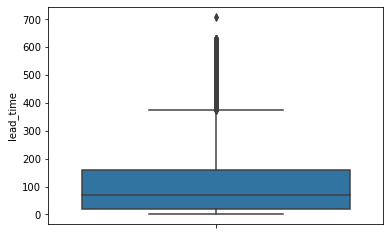

In [84]:
sns.boxplot(data=X_train, y="lead_time")


### Regra n-Sigma: 68-95-99

A regra 68-95-99 de limpeza é calcada na forma da distribuição normal: 99% dos dados estão a menos de 3 desvios padrões da média. Muitas vezes, filtramos outliers utilizando o intervalo de 2-sigmas, descartando 5% das observações com valores mais extremos.

A regra `n-Sigma` é ótima se nossa variável é **simétrica**, ou seja, se a variação para cima da média é semelhante a variação para baixo da média. Caso contrário, podemos descartar muitos dados em um eixo só: por exemplo removendo estes 5% só da parte superior da distribuição.

In [85]:
mu_lead_time = X_train["lead_time"].mean()
sig_lead_time = X_train["lead_time"].std()


In [86]:
mask_95 = (X_train["lead_time"] > (mu_lead_time - 2 * sig_lead_time)) & (
    X_train["lead_time"] < (mu_lead_time + 2 * sig_lead_time)
)
print(mask_95.sum() / X_train.shape[0])


0.9494650555046794


<AxesSubplot:xlabel='out_2sig', ylabel='lead_time'>

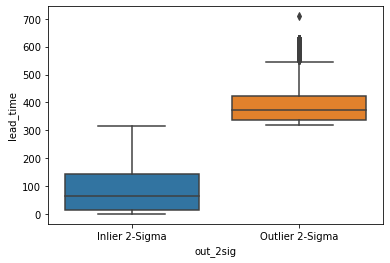

In [87]:
X_train.loc[mask_95, "out_2sig"] = "Inlier 2-Sigma"
X_train.loc[~mask_95, "out_2sig"] = "Outlier 2-Sigma"
sns.boxplot(data=X_train, x="out_2sig", y="lead_time")


Qual o problema com a exclusão acima?

#### Desigualdade de Chebyshev

A desigualdade de Chebyshev é uma extensão da regra n-Sigma para **qualquer distribuição comum (simétrica ou assimétrica)**: ela nos garante que 96% dos dados estarão à 5 desvios padrões da média.

Essa estimativa é extremamente conservadora - o que faz com que exclusão de outliers seja suave. Esta é uma regra **que sempre podemos aplicar sobre variáveis numéricas!**

In [88]:
mask_cheby = (X_train["lead_time"] > (mu_lead_time - 5 * sig_lead_time)) & (
    X_train["lead_time"] < (mu_lead_time + 5 * sig_lead_time)
)
print(mask_cheby.sum() / X_train.shape[0])


0.9999888320564652


<AxesSubplot:xlabel='out_cheby', ylabel='lead_time'>

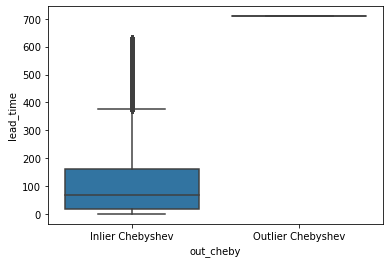

In [89]:
X_train.loc[mask_cheby, "out_cheby"] = "Inlier Chebyshev"
X_train.loc[~mask_cheby, "out_cheby"] = "Outlier Chebyshev"
sns.boxplot(data=X_train, x="out_cheby", y="lead_time")


### Utilizando a IQR

Podemos utilizar a distância interquartil para estimar thresholds de outliers assimétricos. A regra IQR funciona como um meio termo robusto entre a desigualdade de Chebyshev e a regra n-Sigma.

Como esta regra utiliza os *quantis* de uma variável, devemos tomar cuidado com variáveis extremamente concentradas (algo comum em variáveis de contagem por exemplo): nesses cassos muitas vezes o terceiro quartil é igual ao primeiro quartil - levando à uma exclusão de toda variação presente na variável.

In [90]:
q25 = np.quantile(X_train["lead_time"], 0.25)
q75 = np.quantile(X_train["lead_time"], 0.75)
iqr = q75 - q25

In [91]:
mask_iqr = (X_train["lead_time"] > (q25 - 1.5 * iqr)) & (
    X_train["lead_time"] < (q75 + 1.5 * iqr)
)
print(mask_iqr.sum() / X_train.shape[0])


0.9750396461995489


<AxesSubplot:xlabel='out_iqr', ylabel='lead_time'>

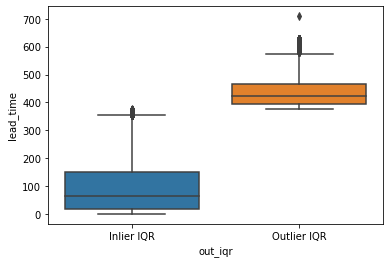

In [92]:
X_train.loc[mask_iqr, "out_iqr"] = "Inlier IQR"
X_train.loc[~mask_iqr, "out_iqr"] = "Outlier IQR"
sns.boxplot(data=X_train, x="out_iqr", y="lead_time")


## Criando normalizador

In [103]:
from sklearn.preprocessing import StandardScaler

In [104]:
num_var = ['lead_time', 'adults', 'children_imp', 'num_meal', 'adr']

In [105]:
scaler = StandardScaler()
scaler.fit(X_train[num_var])

StandardScaler()

In [106]:
scaler.get_feature_names_out()

array(['lead_time', 'adults', 'children_imp', 'num_meal', 'adr'],
      dtype=object)

# Construindo nossos conjuntos de treinamento e teste

1. Podemos alterar o número de linhas **APENAS** no **conjunto de treinamento**;
    * *Isso inclui qualquer operação de limpeza de NAs e outliers.*
1. Qualquer etapa de **aprendizagem** pode ser executada apenas no **conjunto de treinamento**;
    * *Isso inclui encoders (ordinais e OH), imputadores, normalizadores e agrupamento de valores categóricos.*
1. Toda transformação deve ser realizada **tanto no conjunto de teste quanto no conjunto final**.

## Finalizando nosso dataset de treinamento

In [107]:
mu_adults = X_train["adults"].mean()
sig_adults = X_train["adults"].std()
mask_cheby_adults = (X_train["adults"] > (mu_adults - 5 * sig_adults)) & (
    X_train["adults"] < (mu_adults + 5 * sig_adults)
)

In [108]:
mu_child = X_train["children_imp"].mean()
sig_child = X_train["children_imp"].std()
mask_cheby_child = (X_train["children_imp"] > (mu_child - 5 * sig_child)) & (
    X_train["children_imp"] < (mu_child + 5 * sig_child)
)

In [109]:
mu_child = X_train["adr"].mean()
sig_child = X_train["adr"].std()
mask_cheby_child = (X_train["adr"] > (mu_child - 5 * sig_child)) & (
    X_train["adr"] < (mu_child + 5 * sig_child)
)

In [110]:
q25 = np.quantile(X_train["lead_time"], 0.25)
q75 = np.quantile(X_train["lead_time"], 0.75)
iqr = q75 - q25
mask_iqr_lead_time = (X_train["lead_time"] > (q25 - 1.5 * iqr)) & (
    X_train["lead_time"] < (q75 + 1.5 * iqr)
)

In [111]:
mask_inliner = (mask_iqr_lead_time) & (mask_cheby_child) & (mask_cheby_adults)
print(f"Removendo {np.round(100*(1-mask_inliner.sum()/X_train.shape[0]), 2)}% do Train-set")

Removendo 2.55% do Train-set


In [112]:
X_train_nout = X_train.loc[mask_inliner]

In [113]:
X_train_numerical = X_train_nout[num_var]
X_sca = pd.DataFrame(
    scaler.transform(X_train_numerical),
    columns = scaler.get_feature_names_out(),
    index = X_train_nout.index
)

In [114]:
X_dum = pd.DataFrame(
    ohe.transform(X_train_nout[ohe_vars]),
    columns = ohe.get_feature_names_out(),
    index = X_train_nout.index
)
X_dum['is_company'] = X_train_nout['is_company']

In [115]:
X_train_final = pd.concat([X_sca, X_dum], axis = 1)
X_train_final.head()

,lead_time,adults,children_imp,num_meal,adr,country_grp_BEL,country_grp_BRA,country_grp_CHE,country_grp_CN,country_grp_DEU,country_grp_ESP,country_grp_FRA,country_grp_GBR,country_grp_IRL,country_grp_ITA,country_grp_NLD,country_grp_Others,country_grp_PRT,country_grp_USA,is_company
108543,0.505760,0.252875,-0.260251,-0.050305,-0.133620,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
118204,0.618174,0.252875,-0.260251,-0.050305,0.556764,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
16233,-0.974360,0.252875,-0.260251,-0.050305,1.227700,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
10827,-0.534071,-1.504025,-0.260251,-0.050305,0.028377,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
20362,-0.871314,0.252875,-0.260251,-0.050305,-1.981126,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## Finalizando nosso dataset de test

In [116]:
mask_na_company = X_test["company"].isna()
X_test.loc[mask_na_company, "is_company"] = 0
X_test.loc[~mask_na_company, "is_company"] = 1

X_test['country_imp'] = country_imputer.transform(X_test[["country"]])
X_test['children_imp'] = children_imputer.transform(X_test[["children"]])
X_test['country_grp'] = X_test['country_imp'].map(dict_country)
X_test['country_grp'] = X_test['country_grp'].fillna('Others')
X_test['num_meal'] = ordinal.transform(X_test[["meal"]])

In [117]:
X_test_numerical = X_test.loc[:, num_var]
X_sca_test = pd.DataFrame(
    scaler.transform(X_test_numerical),
    columns = scaler.get_feature_names_out(),
    index = X_test_numerical.index
)

In [118]:
X_dum_test = pd.DataFrame(
    ohe.transform(X_test[ohe_vars]),
    columns = ohe.get_feature_names_out(),
    index = X_test.index
)
X_dum_test['is_company'] = X_test['is_company']

In [119]:
X_test_final = pd.concat([X_sca_test, X_dum_test], axis = 1)
X_test_final.head()

,lead_time,adults,children_imp,num_meal,adr,country_grp_BEL,country_grp_BRA,country_grp_CHE,country_grp_CN,country_grp_DEU,country_grp_ESP,country_grp_FRA,country_grp_GBR,country_grp_IRL,country_grp_ITA,country_grp_NLD,country_grp_Others,country_grp_PRT,country_grp_USA,is_company
81161,-0.936889,0.252875,-0.260251,-0.050305,-0.717043,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
55793,0.946049,0.252875,-0.260251,-1.957321,-0.143344,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26189,0.487024,0.252875,-0.260251,-0.050305,0.018070,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
111642,0.149782,0.252875,-0.260251,-0.050305,-0.248360,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
88175,-0.346714,2.009775,-0.260251,1.856712,2.289530,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Salvando nossos conjuntos de teste e treinamento

In [120]:
tb_train = X_train_final
tb_train['is_cancelled'] = y_train
tb_train.to_csv('data/tb_hotel_train_clean.csv', index = False)

In [121]:
tb_test = X_test_final
tb_test['is_cancelled'] = y_test
tb_test.to_csv('data/tb_hotel_test_clean.csv', index = False)

## **EXTRA** - Criando um *wrapper*

In [ ]:
def fit_objects(dados_treinamento):
    # Limpando outliers
    q25 = np.quantile(dados_treinamento["lead_time"], 0.25)
    q75 = np.quantile(dados_treinamento["lead_time"], 0.75)
    iqr = q75 - q25
    mask_iqr = (dados_treinamento["lead_time"] > (q25 - 1.5 * iqr)) & (dados_treinamento["lead_time"] < (q75 + 1.5 * iqr))
    dados_treinamento = dados_treinamento[mask_iqr].copy()
    
    # Criando imputers
    country_imputer = SimpleImputer(strategy="most_frequent")
    dados_treinamento['country_imp'] = country_imputer.fit_transform(dados_treinamento[["country"]])
    children_imputer = SimpleImputer(strategy="median")
    dados_treinamento['children_imp'] = children_imputer.fit_transform(dados_treinamento[["children"]])

    # Criando grupos de países
    tb_niveis_country = dados_treinamento[['country_imp']].value_counts().reset_index().rename({0 : 'num_obs'}, axis = 1)
    mask_niveis = tb_niveis_country["num_obs"] > (sum(tb_niveis_country["num_obs"]) * 0.01)
    tb_niveis_country.loc[mask_niveis, "country_grp"] = tb_niveis_country["country_imp"]
    tb_niveis_country.loc[~mask_niveis, "country_grp"] = "Others"
    tb_niveis_country.index = tb_niveis_country["country_imp"]
    tb_niveis_country = tb_niveis_country.drop(["num_obs", "country_imp"], axis=1)
    dict_country = tb_niveis_country.to_dict()["country_grp"]
    dados_treinamento['country_grp'] = dados_treinamento['country_imp'].map(dict_country)

    # Criando OrdinalEncoder para Meal
    ordinal = OrdinalEncoder(categories=[["Undefined", "SC", "BB", "HB", "FB"]])
    dados_treinamento['num_meal'] = ordinal.fit_transform(dados_treinamento[["meal"]])

    # Criando OneHotEncoder para variáveis categóricas
    ohe_var = ['country_grp']
    ohe = OneHotEncoder(sparse=False, drop="first", handle_unknown="ignore")
    ohe.fit(dados_treinamento[ohe_var])

    # Criando normalizador
    num_var = ['lead_time', 'adults', 'num_meal', 'children_imp']
    scaler = StandardScaler()
    scaler.fit(dados_treinamento[num_var])
    return country_imputer, children_imputer, dict_country, ohe, ordinal, scaler


def transform_data(dados_originais, country_imputer, children_imputer, dict_country, ohe, ordinal, scaler):
    mask_na_company = dados_originais["company"].isna()
    dados_originais.loc[mask_na_company, "is_company"] = 0
    dados_originais.loc[~mask_na_company, "is_company"] = 1

    dados_originais['country_imp'] = country_imputer.transform(dados_originais[["country"]])
    dados_originais['children_imp'] = children_imputer.transform(dados_originais[["children"]])
    dados_originais['country_grp'] = dados_originais['country_imp'].map(dict_country)
    dados_originais['country_grp'] = dados_originais['country_grp'].fillna('Others')
    dados_originais['num_meal'] = ordinal.transform(dados_originais[["meal"]])

    ohe_var = ['country_grp']
    X_dummies = pd.DataFrame(
        ohe.transform(dados_originais[ohe_var]),
        columns = ohe.get_feature_names_out(),
        index = dados_originais.index
    )
    X_dummies['is_company'] = dados_originais['is_company']

    num_var = ['lead_time', 'adults', 'num_meal', 'children_imp']
    X_numerical = pd.DataFrame(
        scaler.transform(dados_originais[num_var]),
        columns = scaler.get_feature_names_out(),
        index = dados_originais.index
    )

    return pd.concat([X_dummies, X_numerical], axis = 1)

In [ ]:
X_var = ["lead_time", "country", "company", "children", "adults", "meal"]
y_var = "is_cancelled"
X = tb_hotel[X_var]
y = tb_hotel[y_var]
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
country_imputer, children_imputer, dict_country, ohe, ordinal, scaler = fit_objects(X_train)
X_train_final = transform_data(X_train, country_imputer, children_imputer, dict_country, ohe, ordinal, scaler)
X_test_final = transform_data(X_test, country_imputer, children_imputer, dict_country, ohe, ordinal, scaler)